In [51]:
from scipy.io import wavfile
import numpy as np
import scipy.signal as sp
import scipy as scipy
import matplotlib.pyplot as plt
import pandas as pd


In [52]:
def read_wav(file):
    samplerate, data = wavfile.read('{}.wav'.format(file))
    print(samplerate,data.shape)
    return samplerate,data
fs1,x1 = read_wav('x1')
fs2,x2 = read_wav('x2')
fs3,x3 = read_wav('x3')
fs_s1,s1 = read_wav('s1')
fs_s2,s2 = read_wav('s2')
fs_s3,s3 = read_wav('s3')

44100 (441000,)
44100 (441000,)
44100 (441000,)
44100 (441000,)
44100 (441000,)
44100 (441000,)


In [53]:
# 標準化
M = len(x1)#信号のサンプル数
x = np.zeros((3, len(x1)))
x[0,:] = (x1 - np.mean(x1))/np.sqrt(np.nanvar(x1))
x[1,:] = (x2 - np.mean(x2))/np.sqrt(np.nanvar(x2))
x[2,:] = (x3 - np.mean(x3))/np.sqrt(np.nanvar(x3))
print(x.shape)

# 観測信号の白色化化
R = np.dot(x, x.T)/M
eig_v, Q = np.linalg.eig(R)
Lambda = np.diag(eig_v)
V = np.dot(np.sqrt(np.linalg.inv(Lambda)), Q.T)
xh = np.dot(V,x)
# b_past = np.eye(3)
# b = np.eye(3)
# def ICA(m_component, max_iter):
#   b_past = np.eye(m_component)
#   b = np.eye(m_component)
#   sh = np.zeros((m_component,xh.shape[1]))
#   for m in range (m_component):
#     for i in range(max_iter):
#       b_past[:, m] = b[:,m]
#       sh[m,:] = np.dot(b[:,m].T, xh)
#       b[0,m] = np.mean(np.dot(np.power(sh[m,:], 3), xh[0,:])) - 3*b[0,m]
#       b[1,m] = np.mean(np.dot(np.power(sh[m,:], 3), xh[1,:])) - 3*b[1,m]
#       b[2,m] = np.mean(np.dot(np.power(sh[m,:], 3), xh[2,:])) - 3*b[2,m]
#       if (m > 0):
#         b_gs = np.zeros((m_component,m_component))
#         for j in range(m):
#           b_gs[0,m] += (b[0,m].T*b[0,j])*b[0,j]
#           b_gs[1,m] += (b[1,m].T*b[1,j])*b[1,j]
#           b_gs[2,m] += (b[2,m].T*b[2,j])*b[2,j]
#         b[0,m] -= b_gs[0,m]
#         b[1,m] -= b_gs[1,m]
#         b[2,m] -= b_gs[2,m]
#       b[:,m] = b[:,m]/np.linalg.norm(b[:,m])
#       if np.abs(np.abs(np.dot(b[:,m].T, b_past[:, m]))-1) < 10**-6:
#         break
#   print(b.T)
#   return sh

b_past = np.array(([1,1,1],[0,0,0],[0,0,0]),dtype=float)
b = np.array(([1,1,1],[0,0,0],[0,0,0]),dtype=float)
print(b.shape)

def ICA(m_component, max_iter):
    for m in range(m_component):
        for i in range(max_iter):
            b_past[:,m] = b[:,m]
            sh = np.dot(b[:,m].T, xh)
            
            # fourth moment - kurtosis
            b[:,m] = np.mean(xh * np.power(sh,3).reshape(1, -1), axis=1) - 3*b[:,m]

            # Gram-Schmidt process
            if m > 0:
                for j in range(m):
                    b[:,m] -= np.dot(np.dot(b[:,m].T, b[:,j]), b[:,j])
            
            # Normalize
            b[:,m] /= np.linalg.norm(b[:,m])
            
            # Check for convergence
            if np.abs(np.abs(np.dot(b[:,m].T, b_past[:,m])) - 1) < 10**-6:
                break
        print("iteration = ",i)
    # Recover Original signals
    return np.dot(b.T, xh)    

sh = ICA(3,100)
print(b.T)

(3, 441000)
(3, 3)
iteration =  8
iteration =  10
iteration =  1
[[ 0.5754632  -0.68548932  0.44603419]
 [ 0.63486286  0.03062626 -0.7720176 ]
 [ 0.51554946  0.72743826  0.452816  ]]


(441000, 6)


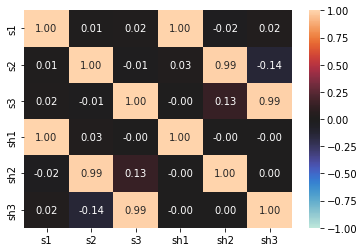

In [54]:
# sh = ICA(3,200)
s = np.vstack((s1,s2,s3))
s_sh = np.concatenate((s,sh),axis= 0).T
print(s_sh.shape)
df = pd.DataFrame(s_sh, columns = ['s1','s2','s3','sh1','sh2','sh3'])
corr_mat = df.corr(method='pearson')
import seaborn as sns
sns.heatmap(corr_mat,
            vmin=-1.0,
            vmax=1.0,
            center=0,
            annot=True, # True:格子の中に値を表示
            fmt='.2f',
            xticklabels=corr_mat.columns.values,
            yticklabels=corr_mat.columns.values
           )
plt.show()


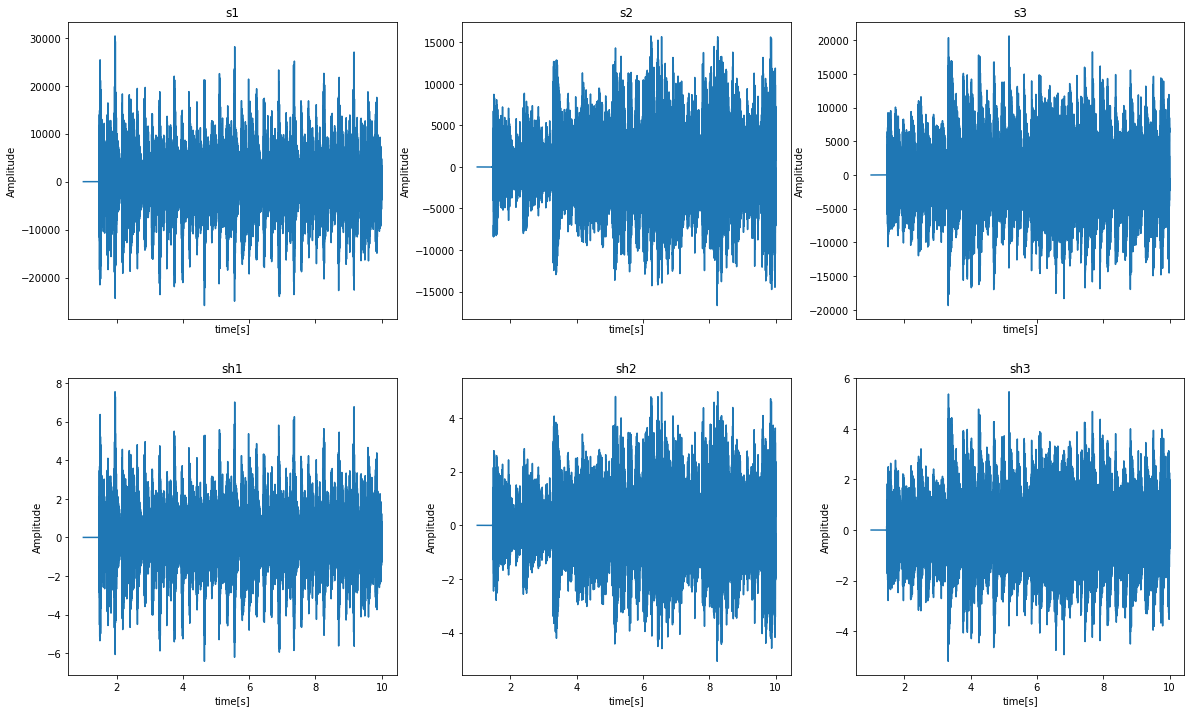

In [55]:
t = np.linspace(1,10,fs_s1*10)
s_title = ["s1","s2","s3"]
sh_title = ["sh1","sh2","sh3"]
fig, axs = plt.subplots(2, 3,figsize=(20, 12),sharex= True)
for i in range(2):
    if (i == 0):
        y = s
        title = s_title
    else:
        y = sh
        title = sh_title
    for j in range(3):
        axs[i, j].plot(t, y[j,:])
        axs[i, j].set_title(title[j])
for ax in axs.flat:
    ax.set(xlabel='time[s]', ylabel='Amplitude')